In [4]:
import numpy as np
import pandas as pd
from pymongo import MongoClient
from sqlalchemy.dialects.mssql.information_schema import columns

In [5]:
# Function to pull data from MongoDB and convert it to DataFrames
def pulling_data_db():
    # Connect to MongoDB
    client = MongoClient('localhost', 27017)
    db = client['financeStockData']

    collection = db['AAPL_stock_data']
    
    # Fetch all documents from each collection
    dt1 = list(collection.find())     # Convert cursor to list for DataFrame
 
    # Convert list of documents (dictionaries) to pandas DataFrames
    appl_data = pd.DataFrame(dt1)
    
    return appl_data # tesl_fin, goo_fin

In [6]:
fin_data = pulling_data_db()
fin_data.head()

,_id,Date,Open,High,Low,Close,Adj Close,Volume
0,671cb50b7e1d0aa4a14f6c7c,2023-10-27,166.910004,168.960007,166.830002,168.220001,167.363586,58499100
1,671cb50b7e1d0aa4a14f6c7d,2023-10-30,169.020004,171.169998,168.869995,170.289993,169.423035,51131000
2,671cb50b7e1d0aa4a14f6c7e,2023-10-31,169.350006,170.899994,167.899994,170.770004,169.900604,44846000
3,671cb50b7e1d0aa4a14f6c7f,2023-11-01,171.000000,174.229996,170.119995,173.970001,173.084320,56934900
4,671cb50b7e1d0aa4a14f6c80,2023-11-02,175.520004,177.779999,175.460007,177.570007,176.665985,77334800


In [7]:
fin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   _id        252 non-null    object 
 1   Date       252 non-null    object 
 2   Open       252 non-null    float64
 3   High       252 non-null    float64
 4   Low        252 non-null    float64
 5   Close      252 non-null    float64
 6   Adj Close  252 non-null    float64
 7   Volume     252 non-null    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 15.9+ KB


<Axes: >

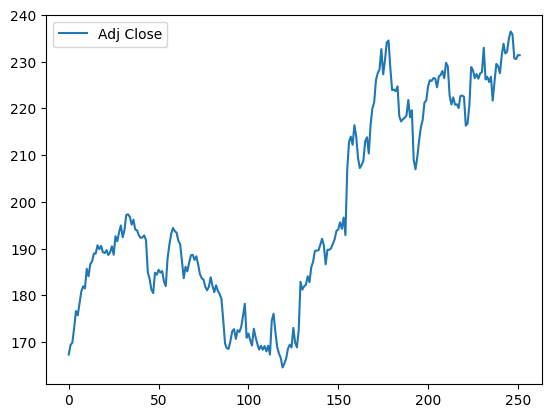

In [8]:
fin_data = fin_data[["Date", "Adj Close"]]
fin_data.plot(kind='line')

In [22]:
# Step 2: Ensure the index is a DatetimeIndex
fin_data.index = pd.to_datetime(fin_data.index)

In [23]:
# resampling to bi-weekly 
weekly_price = fin_data['Adj Close'].resample('W').mean()
monthly_price = fin_data['Adj Close'].resample('M').mean()
daily_price = fin_data['Adj Close'].resample('D').mean()

print(f"Weekly average price of stock is {weekly_price}")
print(f"Monthly average price of stock is {monthly_price}")
print(f"Daily average price of stock is {daily_price}")

Weekly average price of stock is 1970-01-04    197.037268
Freq: W-SUN, Name: Adj Close, dtype: float64
Monthly average price of stock is 1970-01-31    197.037268
Freq: M, Name: Adj Close, dtype: float64
Daily average price of stock is 1970-01-01    197.037268
Freq: D, Name: Adj Close, dtype: float64


In [24]:
fin_data['Date'] = pd.to_datetime(fin_data['Date'])
fin_data['month'] = fin_data['Date'].dt.month
fin_data['day'] = fin_data['Date'].dt.day
fin_data['year'] = fin_data['Date'].dt.year
fin_data.head()

,Date,Adj Close,month,day,year
1970-01-01 00:00:00.000000000,2023-10-23,172.119263,10,23,2023
1970-01-01 00:00:00.000000001,2023-10-24,172.557007,10,24,2023
1970-01-01 00:00:00.000000002,2023-10-25,170.228943,10,25,2023
1970-01-01 00:00:00.000000003,2023-10-26,166.040375,10,26,2023
1970-01-01 00:00:00.000000004,2023-10-27,167.363586,10,27,2023


In [25]:
fin_data = fin_data.drop(columns = ['Date'], axis =1)
fin_data.head()

,Adj Close,month,day,year
1970-01-01 00:00:00.000000000,172.119263,10,23,2023
1970-01-01 00:00:00.000000001,172.557007,10,24,2023
1970-01-01 00:00:00.000000002,170.228943,10,25,2023
1970-01-01 00:00:00.000000003,166.040375,10,26,2023
1970-01-01 00:00:00.000000004,167.363586,10,27,2023


In [26]:
fin_data.duplicated().sum()

0

In [27]:
fin_data['Adj Close'].describe()

count    251.000000
mean     197.037268
std       21.246716
min      164.585999
25%      181.367706
50%      190.835846
75%      219.810570
max      236.479996
Name: Adj Close, dtype: float64

In [28]:
df = fin_data.values.flatten()

In [29]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):

    print('Results of Dickey-Fuller Test:')
    adf_test_result = adfuller(timeseries, autolag='AIC')
    
    adf_output = pd.Series(adf_test_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in adf_test_result[4].items():
        adf_output['Critical Value (%s)' % key] = value
    
    print(adf_output)

    # Interpret the p-value
    if adf_output['p-value'] < 0.05:
        print("\nConclusion: Reject the null hypothesis. The time series is stationary.")
    else:
        print("\nConclusion: Cannot reject the null hypothesis. The time series is non-stationary.")


In [30]:
adf_test(df)

Results of Dickey-Fuller Test:
Test Statistic                   -1.876931
p-value                           0.342990
#Lags Used                        3.000000
Number of Observations Used    1000.000000
Critical Value (1%)              -3.436906
Critical Value (5%)              -2.864435
Critical Value (10%)             -2.568311
dtype: float64

Conclusion: Cannot reject the null hypothesis. The time series is non-stationary.


In [34]:
season_length = 1
df_diff = fin_data['Adj Close'].diff(periods=season_length).dropna()  # Adjust season_length accordingly
df_diff

1970-01-01 00:00:00.000000001    0.437744
1970-01-01 00:00:00.000000002   -2.328064
1970-01-01 00:00:00.000000003   -4.188568
1970-01-01 00:00:00.000000004    1.323212
1970-01-01 00:00:00.000000005    2.059448
                                   ...   
1970-01-01 00:00:00.000000246    2.550003
1970-01-01 00:00:00.000000247   -2.070007
1970-01-01 00:00:00.000000248    0.369995
1970-01-01 00:00:00.000000249    2.850006
1970-01-01 00:00:00.000000250    1.479996
Name: Adj Close, Length: 250, dtype: float64

<Axes: >

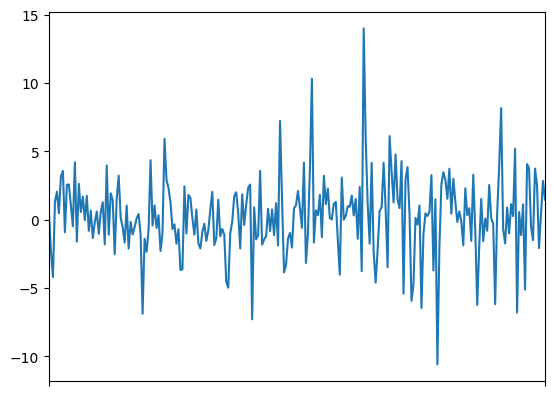

In [36]:
# df = pd.DataFrame(df_diff)
df_diff.plot(kind="line")

In [37]:
adf_test(df_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.505817e+01
p-value                        9.085808e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64

Conclusion: Reject the null hypothesis. The time series is stationary.


In [38]:
df_smoothed = df_diff.rolling(window=2).mean()  # Adjust window size
df_smoothed.dropna(inplace=True)

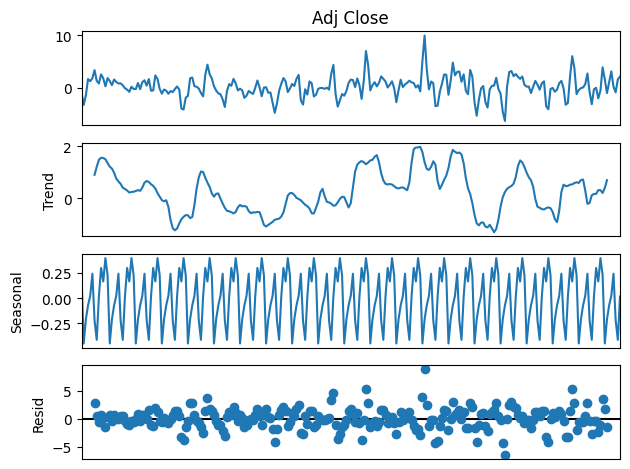

In [39]:
# Checking for trend in the time series data
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomposition = seasonal_decompose(df_smoothed, model='additive', period=12)  # Adjust 'period'

# Plot the decomposed components
decomposition.plot()
plt.show()

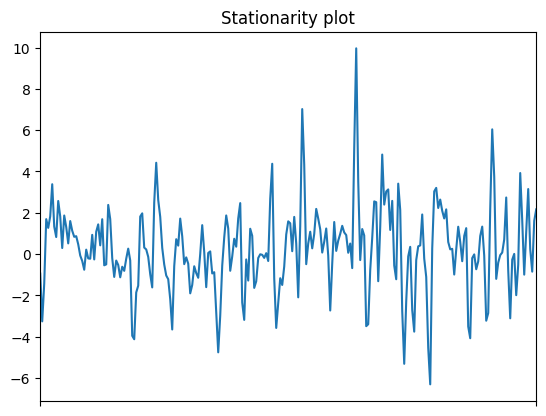

In [42]:
df_smoothed.plot(kind='line', title="Stationarity plot");